D:\Anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost: R¬≤ = 0.6953, RMSE = 0.0458


D:\Anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RandomForest: R¬≤ = 0.4023, RMSE = 0.0641
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9224
[LightGBM] [Info] Number of data points in the train set: 68722, number of used features: 41
[LightGBM] [Info] Start training from score 0.660257
LightGBM: R¬≤ = 0.5682, RMSE = 0.0545
LinearRegression: R¬≤ = 0.2890, RMSE = 0.0699


D:\Anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


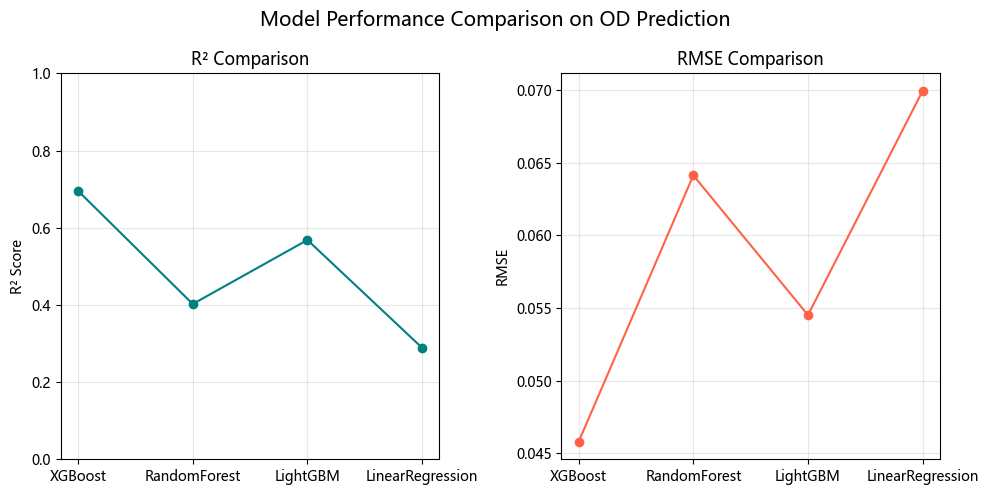

In [100]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# === Êï∞ÊçÆËØªÂèñ‰∏éÂ§ÑÁêÜ ===
gdf = gpd.read_file("‰øùÂ≠òÁªìÊûúÁî®/SZ_model_input_CPL_renamed.geojson")
gdf_filtered = gdf[(gdf['log_d30_norm'] != 0) & (gdf['allow_uses_label'] != 0)]

exclude_cols = [
    'log_d10_norm', 'log_d20_norm', 'log_d30_norm',  'poi_entropy100', 'poi_entropy200',
    'geometry', 'new_id','clo','deg_C','betw1000K','allow_uses_label',
    'L_filtered_weibo_count','C_length','L_poi_entropy200','L_poi_entropy100'
]
feature_cols = [col for col in gdf_filtered.columns if col not in exclude_cols]

X = gdf_filtered[feature_cols]
y = gdf_filtered['log_d30_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === ÂÆö‰πâÊ®°ÂûãÂàóË°® ===
models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=8, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=200, max_depth=8, random_state=42),
    'LinearRegression': LinearRegression()
}

# === ËÆ∞ÂΩïÊÄßËÉΩ ===
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    results.append({'Model': name, 'R2': r2, 'RMSE': rmse})
    print(f"{name}: R¬≤ = {r2:.4f}, RMSE = {rmse:.4f}")

# === ÂèØËßÜÂåñÊØîËæÉ ===
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 5))

# R2 ÊäòÁ∫øÂõæ
plt.subplot(1, 2, 1)
plt.plot(results_df['Model'], results_df['R2'], marker='o', color='teal')
plt.title("R¬≤ Comparison")
plt.ylabel("R¬≤ Score")
plt.ylim(0, 1)
plt.grid(alpha=0.3)

# RMSE ÊäòÁ∫øÂõæ
plt.subplot(1, 2, 2)
plt.plot(results_df['Model'], results_df['RMSE'], marker='o', color='tomato')
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.grid(alpha=0.3)

plt.suptitle("Model Performance Comparison on OD Prediction", fontsize=14)
plt.tight_layout()
plt.show()


In [101]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

# Ëá™ÂÆö‰πâ RMSE ËØÑÂàÜÂáΩÊï∞ÔºàË¥üÂÄºÁî®‰∫é cross_val_scoreÔºâ
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

# ÂçÅÊäò‰∫§ÂèâÈ™åËØÅÂô®
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Â≠òÂÇ®ÁªìÊûú
cv_results = []

for name, model in models.items():
    # R¬≤‰∫§ÂèâÈ™åËØÅ
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    # RMSE‰∫§ÂèâÈ™åËØÅÔºàÊ≥®ÊÑèÂèñË¥üÊï∞ÂêéËøòÂéüÔºâ
    rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
    
    cv_results.append({
        'Model': name,
        'CV_R2_Mean': np.mean(r2_scores),
        'CV_R2_Std': np.std(r2_scores),
        'CV_RMSE_Mean': -np.mean(rmse_scores),
        'CV_RMSE_Std': np.std(rmse_scores)
    })

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9224
[LightGBM] [Info] Number of data points in the train set: 77312, number of used features: 41
[LightGBM] [Info] Start training from score 0.660274
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9224
[LightGBM] [Info] Number of data points in the train set: 77312, number of used features: 41
[LightGBM] [Info] Start training from score 0.660279
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

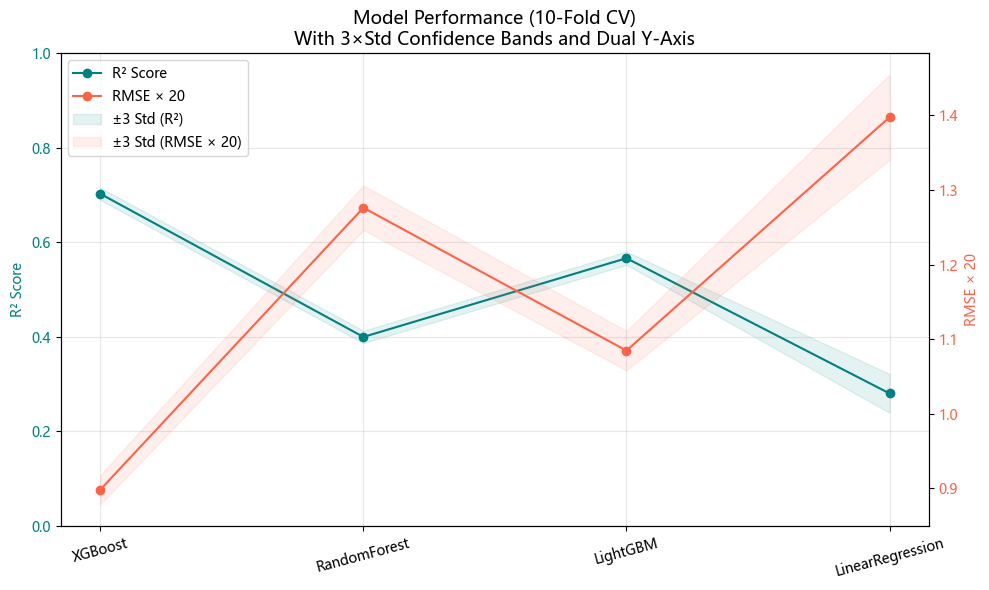

In [106]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# ÂáÜÂ§áÊï∞ÊçÆ
x = np.arange(len(cv_results_df['Model']))
labels = cv_results_df['Model']

r2_mean = cv_results_df['CV_R2_Mean']
r2_std = cv_results_df['CV_R2_Std']
r2_upper = r2_mean + 3 * r2_std
r2_lower = r2_mean - 3 * r2_std

rmse_mean = cv_results_df['CV_RMSE_Mean']
rmse_std = cv_results_df['CV_RMSE_Std']
rmse_upper = rmse_mean + 3 * rmse_std
rmse_lower = rmse_mean - 3 * rmse_std

rmse_scale = 20  # Â∞Ü RMSE ‰πò‰ª• 20 ÊòæÁ§∫

# ÁªòÂõæ
fig, ax1 = plt.subplots(figsize=(10, 6))

# Â∑¶ËΩ¥ÔºöR¬≤
ax1.plot(x, r2_mean, label="R¬≤ Score", color='teal', marker='o')
ax1.fill_between(x, r2_lower, r2_upper, color='teal', alpha=0.1)
ax1.set_ylabel("R¬≤ Score", color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_ylim(0, 1)

# Âè≥ËΩ¥ÔºöRMSE √ó scale
ax2 = ax1.twinx()
ax2.plot(x, rmse_mean * rmse_scale, label=f"RMSE √ó {rmse_scale}", color='tomato', marker='o')
ax2.fill_between(x, rmse_lower * rmse_scale, rmse_upper * rmse_scale, color='tomato', alpha=0.1)
ax2.set_ylabel(f"RMSE √ó {rmse_scale}", color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato')

# XËΩ¥‰∏éÊ†áÈ¢ò
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=15)
ax1.set_title("Model Performance (10-Fold CV)\nWith 3√óStd Confidence Bands and Dual Y-Axis", fontsize=13)
ax1.grid(alpha=0.3)

# === Âõæ‰æãÂêàÂπ∂ÔºàÂê´ÊâãÂä®Ë°•ÂÖÖÁΩÆ‰ø°Âå∫Èó¥ËØ¥ÊòéÔºâ ===
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Ê∑ªÂä†ÁΩÆ‰ø°Âå∫Èó¥ËØ¥ÊòéÂõæ‰æãÈ°πÔºàÈÄèÊòé PatchÔºâ
std_patch_r2 = mpatches.Patch(color='teal', alpha=0.1, label="¬±3 Std (R¬≤)")
std_patch_rmse = mpatches.Patch(color='tomato', alpha=0.1, label=f"¬±3 Std (RMSE √ó {rmse_scale})")

# ÂêàÂπ∂Âõæ‰æã
ax1.legend(lines_1 + lines_2 + [std_patch_r2, std_patch_rmse],
           labels_1 + labels_2 + ["¬±3 Std (R¬≤)", f"¬±3 Std (RMSE √ó {rmse_scale})"],
           loc='upper left')

plt.tight_layout()
plt.savefig("‰øùÂ≠òÁªìÊûúÁî®/‰∫§ÂèâÈ™åËØÅ.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()


‚úÖ ‰∫∫Âè£Ê†ÖÊ†º CRS: EPSG:4326
üó∫Ô∏è Ê†ÖÊ†ºËæπÁïåËåÉÂõ¥: BoundingBox(left=73.498333333333, bottom=15.695000015125004, right=135.08749997536398, top=53.561666666645)


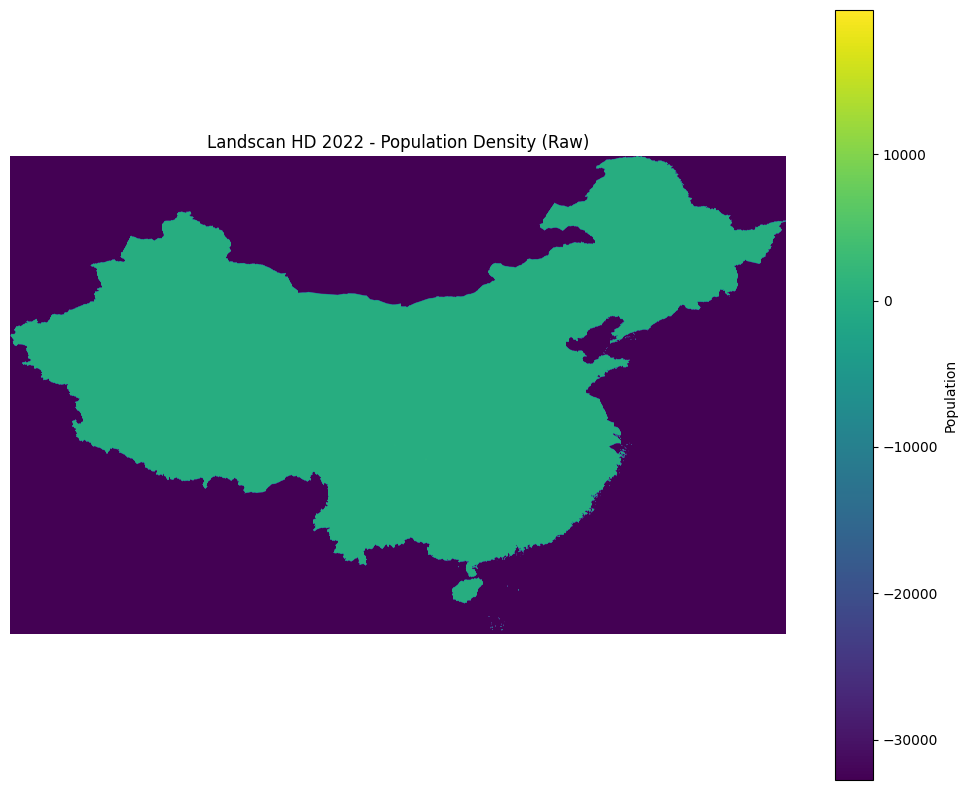

In [17]:
import rasterio
import matplotlib.pyplot as plt

# Ë∑ØÂæÑ
pop_raster_path = "‰∏≠ÂõΩ90Á±≥ÂàÜËæ®Áéá‰∫∫Âè£ÂØÜÂ∫¶ÂàÜÂ∏É2022/landscan-hd-2022-china-v1.tif"

# ÊâìÂºÄÂπ∂ËØªÂèñ‰∫∫Âè£Ê†ÖÊ†º
with rasterio.open(pop_raster_path) as src:
    pop_data = src.read(1)  # ËØªÂèñÁ¨¨‰∏Ä‰∏™Ê≥¢ÊÆµ
    pop_crs = src.crs
    pop_bounds = src.bounds

    # ËæìÂá∫‰ø°ÊÅØ
    print("‚úÖ ‰∫∫Âè£Ê†ÖÊ†º CRS:", pop_crs)
    print("üó∫Ô∏è Ê†ÖÊ†ºËæπÁïåËåÉÂõ¥:", pop_bounds)

    # ÂèØËßÜÂåñ
    plt.figure(figsize=(10, 8))
    plt.imshow(pop_data, cmap='viridis')
    plt.title("Landscan HD 2022 - Population Density (Raw)")
    plt.colorbar(label="Population")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_23792\3937338484.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  sz_union_geom = [admin_gdf_4326.unary_union]


‚úÖ Â∑≤ÊàêÂäüË£ÅÂâ™Âπ∂‰øùÂ≠òËá≥: ‰øùÂ≠òÁªìÊûúÁî®/pop_cropped_sz.tif


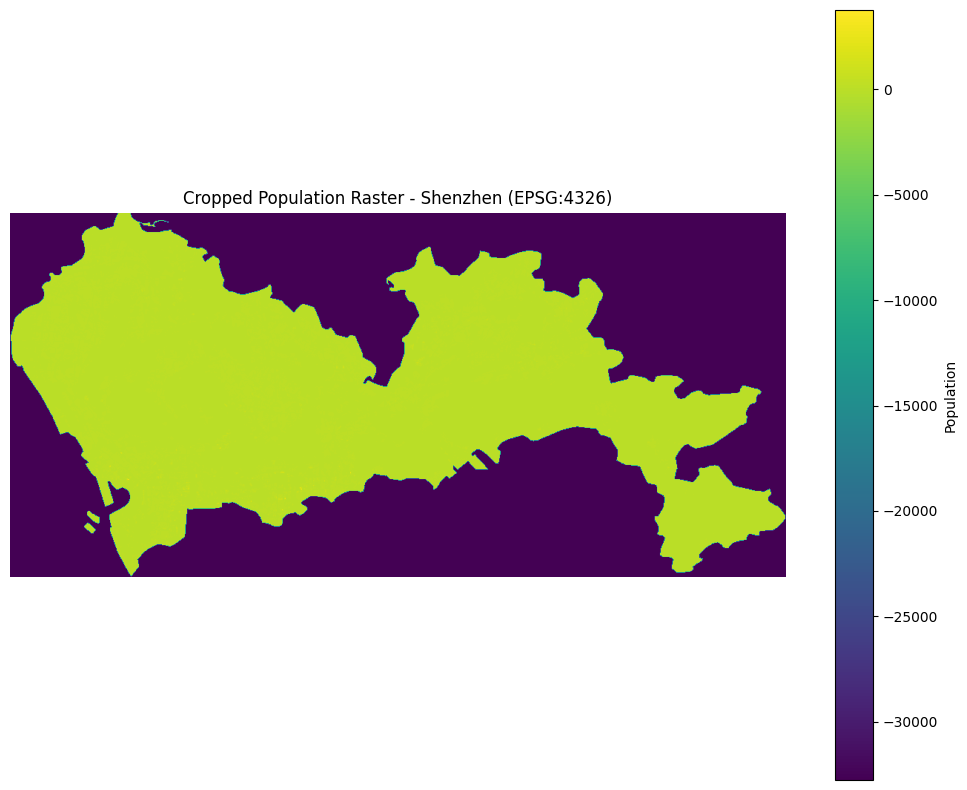

In [18]:
admin_path = "Ë°åÊîøËæπÁïå/Ê∑±Âú≥_ÂéøÁ∫ßÂå∫Âàí.shp"
output_cropped_path = "‰øùÂ≠òÁªìÊûúÁî®/pop_cropped_sz.tif"

# === 1. ËØªÂèñÊ∑±Âú≥ËæπÁïåÂπ∂Áªü‰∏Ä‰∏∫ EPSG:4326 ===
admin_gdf = gpd.read_file(admin_path)
admin_gdf_4326 = admin_gdf.to_crs("EPSG:4326")

# Ëé∑ÂèñÊ∑±Âú≥Â∏ÇÊï¥‰ΩìËæπÁïåÔºàÂêàÂπ∂ÊâÄÊúâÂå∫Ôºâ
sz_union_geom = [admin_gdf_4326.unary_union]

# === 2. ËØªÂèñÂéüÂßã‰∫∫Âè£Ê†ÖÊ†ºÂπ∂Ë£ÅÂâ™ ===
with rasterio.open(pop_raster_path) as src:
    assert src.crs.to_string() == "EPSG:4326", "‚ö†Ô∏è Ê†ÖÊ†ºÊú™Â§Ñ‰∫é EPSG:4326ÔºåËØ∑ÂÖàÈáçÊäïÂΩ±"
    
    out_image, out_transform = mask(src, sz_union_geom, crop=True)
    out_meta = src.meta.copy()

out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# === 3. ‰øùÂ≠òË£ÅÂâ™ÁªìÊûú ===
with rasterio.open(output_cropped_path, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"‚úÖ Â∑≤ÊàêÂäüË£ÅÂâ™Âπ∂‰øùÂ≠òËá≥: {output_cropped_path}")

# === 4. ÂèØËßÜÂåñÁªìÊûú ===
plt.figure(figsize=(10, 8))
plt.imshow(out_image[0], cmap='viridis')
plt.title("Cropped Population Raster - Shenzhen (EPSG:4326)")
plt.colorbar(label="Population")
plt.axis('off')
plt.tight_layout()
plt.show()

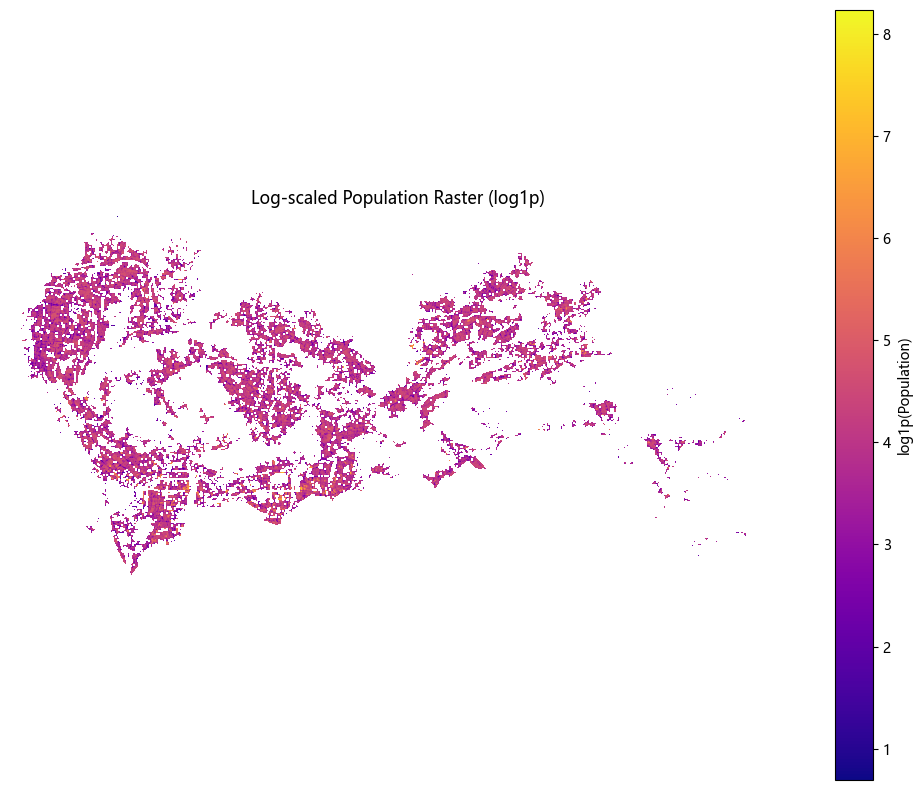

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# ËØªÂèñÂ∑≤Ë£ÅÂâ™ tif
with rasterio.open("‰øùÂ≠òÁªìÊûúÁî®/pop_cropped_sz.tif") as src:
    pop_data = src.read(1)

# ËÆæÁΩÆË¥üÂÄº‰∏∫ nanÔºåÈÅøÂÖçÂΩ±Âìç log ÂèòÊç¢
pop_data = np.where(pop_data > 0, pop_data, np.nan)
pop_log = np.log1p(pop_data)

# ÁªòÂõæ
plt.figure(figsize=(10, 8))
plt.imshow(pop_log, cmap='plasma')
plt.colorbar(label='log1p(Population)')
plt.title("Log-scaled Population Raster (log1p)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [197]:
import rasterio
from rasterio.transform import Affine

# === ÊâìÂºÄÂéüÊñá‰ª∂Ëé∑ÂèñÂÖÉ‰ø°ÊÅØ ===
with rasterio.open("‰øùÂ≠òÁªìÊûúÁî®/pop_cropped_sz.tif") as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs

# === Êõ¥Êñ∞ÂÖÉ‰ø°ÊÅØ ===
meta.update({
    "dtype": "float32",
    "nodata": np.nan
})

# === ÂÜôÂÖ•Êñ∞ÁöÑÂØπÊï∞Âåñ tif Êñá‰ª∂ ===
with rasterio.open("‰øùÂ≠òÁªìÊûúÁî®/pop_log_scaled.tif", "w", **meta) as dst:
    dst.write(pop_log.astype("float32"), 1)

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import box

# === Ë∑ØÂæÑÂÆö‰πâ ===
gdf_path = "‰øùÂ≠òÁªìÊûúÁî®/SZ_model_input_CPL_renamed.geojson"
admin_path = "Ë°åÊîøËæπÁïå/Ê∑±Âú≥_ÂéøÁ∫ßÂå∫Âàí.shp"
shap_path = "‰øùÂ≠òÁªìÊûúÁî®/Guangming_shap_all.csv"

# === 1. ËØªÂèñÊï∞ÊçÆÂπ∂Áªü‰∏Ä CRS ===
input_gdf = gpd.read_file(gdf_path)
admin_gdf = gpd.read_file(admin_path).to_crs(input_gdf.crs)
shap_df = pd.read_csv(shap_path)
input_gdf = input_gdf.merge(shap_df, on='new_id')  # ÂêàÂπ∂ SHAP ÂÄº

# === 2. ÊèêÂèñÁ¶èÁî∞Âå∫ + 1000m ÁºìÂÜ≤Âå∫ ===
futian_poly = admin_gdf[admin_gdf['ÂéøÁ∫ß'] == 'ÂÖâÊòéÂå∫'].geometry.values[0]
futian_buffer = gpd.GeoDataFrame(geometry=[futian_poly.buffer(1000)], crs=input_gdf.crs)

# === 3. Ë£ÅÂâ™Êï∞ÊçÆÈõÜ‰∏∫ÂàÜÊûêÂå∫ÂüüÔºàÈÅìË∑Ø + SHAPÔºâ===
gdf_clip = input_gdf[input_gdf.geometry.centroid.within(futian_buffer.geometry.values[0])]

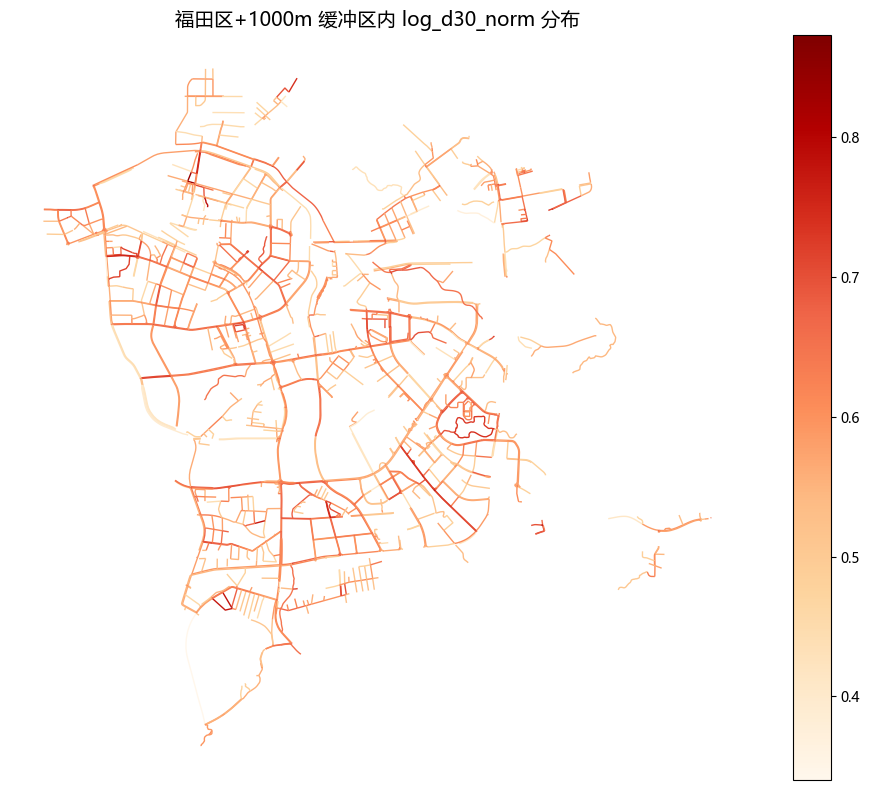

In [287]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# ËøáÊª§ÈùûÁ©∫ÂÄº
gdf_clip_valid = gdf_clip[~gdf_clip['log_d30_norm'].isna()]

# ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰ΩìÔºåÈÅøÂÖç‰π±Á†Å
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# ÁªòÂõæ
fig, ax = plt.subplots(figsize=(10, 8))
gdf_clip_valid.plot(
    column='log_d30_norm',
    cmap='OrRd',  # Êîπ‰∏∫Êõ¥ÂÆπÊòìËæ®ËØÜÁöÑÈ¢úËâ≤
    legend=True,
    linewidth=1,
    ax=ax
)

plt.title("Á¶èÁî∞Âå∫+1000m ÁºìÂÜ≤Âå∫ÂÜÖ log_d30_norm ÂàÜÂ∏É", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


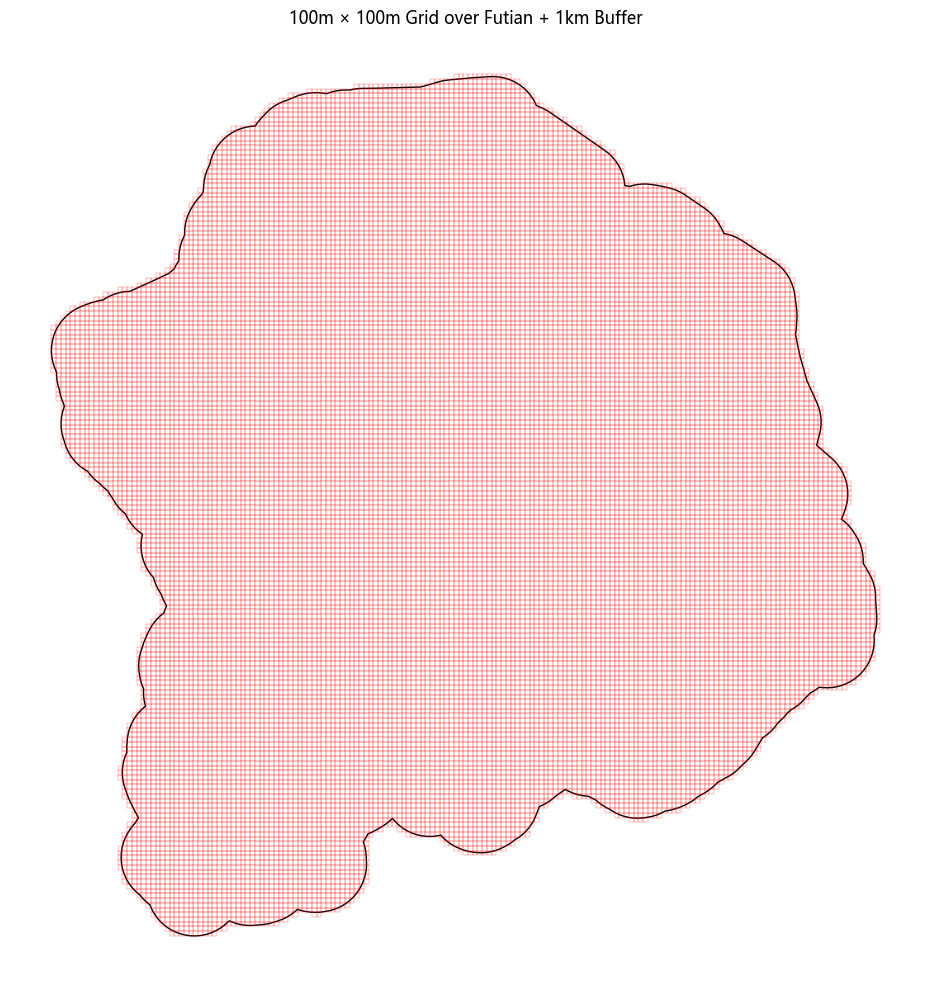

In [289]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np
# ‰ªé admin_gdf ÊèêÂèñÂπ∂ÁºìÂÜ≤ÔºåÁ°Æ‰øùÊòØ GeoDataFrame
futian_buffer = admin_gdf[admin_gdf['ÂéøÁ∫ß'] == 'ÂÖâÊòéÂå∫'].copy()
futian_buffer['geometry'] = futian_buffer.buffer(1000)
futian_buffer = futian_buffer.set_geometry('geometry')

# === Ëé∑ÂèñÁºìÂÜ≤Âå∫ËæπÁïåËåÉÂõ¥ ===
minx, miny, maxx, maxy = futian_buffer.total_bounds

# === ËÆæÁΩÆÁΩëÊ†ºÂ§ßÂ∞èÔºàÂçï‰Ωç‰∏é CRS ‰∏ÄËá¥ÔºåÈÄöÂ∏∏‰∏∫Á±≥Ôºâ ===
grid_size = 100

# === ÊûÑÈÄ†ÁΩëÊ†ºÂùêÊ†áÂ∫èÂàó ===
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

# === ÊûÑÈÄ†ÁΩëÊ†ºÂ§öËæπÂΩ¢ÂàóË°® ===
polygons = [
    box(x, y, x + grid_size, y + grid_size)
    for x in x_coords
    for y in y_coords
]

# === ËΩ¨‰∏∫ GeoDataFrame Âπ∂Á≠õÈÄâ‰∏éÁºìÂÜ≤Âå∫Áõ∏‰∫§ÈÉ®ÂàÜ ===
grid = gpd.GeoDataFrame(geometry=polygons, crs=input_gdf.crs)
grid = grid[grid.intersects(futian_buffer.geometry.values[0])].reset_index(drop=True)

# === ÂèØËßÜÂåñ ===
fig, ax = plt.subplots(figsize=(10, 10))
futian_buffer.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
grid.boundary.plot(ax=ax, color='red', linewidth=0.3, alpha=0.6)
plt.title("100m √ó 100m Grid over Futian + 1km Buffer")
plt.axis('off')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

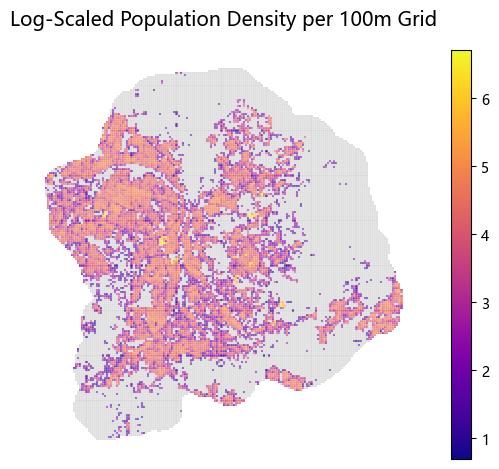

In [290]:
grid_wgs84 = grid.to_crs(epsg=4326)  # ËΩ¨Êç¢‰∏∫ÁªèÁ∫¨Â∫¶ CRS

# === 2. ËÆæÁΩÆË∑ØÂæÑ ===
# pop_tif_path = "‰øùÂ≠òÁªìÊûúÁî®/pop_log_scaled.tif"

# === 3. ÊèêÂèñÊØè‰∏™ÁΩëÊ†ºÂÜÖÁöÑÂπ≥Âùá‰∫∫Âè£ÂØÜÂ∫¶ ===
stats = zonal_stats(
    vectors=grid_wgs84['geometry'],
    raster=pop_tif_path,
    stats=["mean"],
    nodata=np.nan
)

# === 4. ÂÜôÂÖ•ÁªìÊûú ===
grid['pop_mean'] = [s['mean'] if s['mean'] is not None else np.nan for s in stats]

# === ÂèØËßÜÂåñ ===
plt.figure(figsize=(10, 8))
ax = grid.plot(
    column='pop_mean',
    cmap='plasma',
    legend=True,
    edgecolor='white',
    linewidth=0.2,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

# === ÁæéÂåñ ===
plt.title("Log-Scaled Population Density per 100m Grid", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [182]:
grid

geometry  pop_mean
0      POLYGON ((165387.91 2513236.448, 165387.91 251...       NaN
1      POLYGON ((165387.91 2513336.448, 165387.91 251...       NaN
2      POLYGON ((165387.91 2513436.448, 165387.91 251...       NaN
3      POLYGON ((165387.91 2513536.448, 165387.91 251...       NaN
4      POLYGON ((165387.91 2513636.448, 165387.91 251...       NaN
...                                                  ...       ...
51301  POLYGON ((190287.91 2513436.448, 190287.91 251...       NaN
51302  POLYGON ((190287.91 2513536.448, 190287.91 251...       NaN
51303  POLYGON ((190287.91 2513636.448, 190287.91 251...       NaN
51304  POLYGON ((190287.91 2513736.448, 190287.91 251...       NaN
51305  POLYGON ((190287.91 2513836.448, 190287.91 251...       NaN

[51306 rows x 2 columns]

In [291]:
import geopandas as gpd
import numpy as np
from tqdm import tqdm

# === Á°Æ‰øù gdf_clip ‰∏∫ÂâØÊú¨Âπ∂Ê∑ªÂä†ÈïøÂ∫¶Âàó ===
gdf_clip = gdf_clip.copy()
gdf_clip['length'] = gdf_clip.geometry.length

# === ÂæÖËÅöÂêàÂ≠óÊÆµÔºàÂê´ SHAP ‰∏éÁúüÂÄºÔºâ===
columns_to_agg = [col for col in gdf_clip.columns if col.startswith(('C_', 'P_', 'L_', 'O_'))] + ['log_d30_norm']

# === ÂàùÂßãÂåñÁªìÊûú DataFrame ===
grid_result = grid.copy()
for col in columns_to_agg:
    grid_result[col] = np.nan

# === Âª∫Á´ãÁ©∫Èó¥Á¥¢ÂºïÔºàÂä†ÈÄüÔºâ===
sindex = gdf_clip.sindex

# === Âä†ÊùÉÂπ≥ÂùáËÆ°ÁÆóÔºàÊåâË∑ØÊÆµ‰∏éÁΩëÊ†ºÁõ∏‰∫§ÈïøÂ∫¶Ôºâ===
for idx, grid_row in tqdm(grid.iterrows(), total=len(grid), desc="üìä Âä†ÊùÉËÅöÂêà"):
    grid_geom = grid_row.geometry
    possible_matches_idx = list(sindex.intersection(grid_geom.bounds))
    possible_matches = gdf_clip.iloc[possible_matches_idx]
    precise_matches = possible_matches[possible_matches.intersects(grid_geom)]

    if precise_matches.empty:
        continue

    intersected = precise_matches.copy()
    intersected['weight'] = intersected.geometry.intersection(grid_geom).length
    weight_sum = intersected['weight'].sum()

    if weight_sum == 0:
        continue

    for col in columns_to_agg:
        weighted_mean = (intersected[col] * intersected['weight']).sum() / weight_sum
        grid_result.at[idx, col] = weighted_mean

print("‚úÖ Âä†ÊùÉÂπ≥ÂùáÂ∑≤ÂÆåÊàêÔºåÁªìÊûú‰øùÂ≠òÂú® grid_result ‰∏≠„ÄÇ")


üìä Âä†ÊùÉËÅöÂêà: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 22238/22238 [00:28<00:00, 768.75it/s]

‚úÖ Âä†ÊùÉÂπ≥ÂùáÂ∑≤ÂÆåÊàêÔºåÁªìÊûú‰øùÂ≠òÂú® grid_result ‰∏≠„ÄÇ


In [177]:
grid_result

geometry  pop_mean  \
0      POLYGON ((173379.066 2491362.318, 173379.066 2...       NaN   
1      POLYGON ((173379.066 2491462.318, 173379.066 2...       NaN   
2      POLYGON ((173379.066 2491562.318, 173379.066 2...       NaN   
3      POLYGON ((173379.066 2491662.318, 173379.066 2...       NaN   
4      POLYGON ((173379.066 2491762.318, 173379.066 2...       NaN   
...                                                  ...       ...   
25675  POLYGON ((194779.066 2501562.318, 194779.066 2...       NaN   
25676  POLYGON ((194779.066 2501662.318, 194779.066 2...       NaN   
25677  POLYGON ((194779.066 2501762.318, 194779.066 2...       NaN   
25678  POLYGON ((194779.066 2501862.318, 194779.066 2...  2.615554   
25679  POLYGON ((194779.066 2501962.318, 194779.066 2...  2.708050   

       C_Direction_x  C_length  C_lanes_x  C_free_speed_x  C_capacity_x  \
0                NaN       NaN        NaN             NaN           NaN   
1                NaN       NaN        NaN             NaN           NaN   
2                NaN       NaN        NaN             NaN           NaN   
3                NaN       NaN        NaN             NaN           NaN   
4                NaN       NaN        NaN             NaN           NaN   
...              ...       ...        ...             ...           ...   
25675            NaN       NaN        NaN             NaN           NaN   
25676            NaN       NaN        NaN             NaN           NaN   
25677            NaN       NaN        NaN             NaN           NaN   
25678            NaN       NaN        NaN             NaN           NaN   
25679            NaN       NaN        NaN             NaN           NaN   

       C_link_type_x  L_poi_entropy300_x  L_poi_entropy200  ...  P_person_y  \
0                NaN                 NaN               NaN  ...         NaN   
1                NaN                 NaN               NaN  ...         NaN   
2                NaN                 NaN               NaN  ...         NaN   
3                NaN                 NaN               NaN  ...         NaN   
4                NaN                 NaN               NaN  ...         NaN   
...              ...                 ...               ...  ...         ...   
25675            NaN                 NaN               NaN  ...         NaN   
25676            NaN                 NaN               NaN  ...         NaN   
25677            NaN                 NaN               NaN  ...         NaN   
25678            NaN                 NaN               NaN  ...         NaN   
25679            NaN                 NaN               NaN  ...         NaN   

       P_rider_y  P_car_y  P_truck_y  P_bus_y  P_train_y  P_motorcycle_y  \
0            NaN      NaN        NaN      NaN        NaN             NaN   
1            NaN      NaN        NaN      NaN        NaN             NaN   
2            NaN      NaN        NaN      NaN        NaN             NaN   
3            NaN      NaN        NaN      NaN        NaN             NaN   
4            NaN      NaN        NaN      NaN        NaN             NaN   
...          ...      ...        ...      ...        ...             ...   
25675        NaN      NaN        NaN      NaN        NaN             NaN   
25676        NaN      NaN        NaN      NaN        NaN             NaN   
25677        NaN      NaN        NaN      NaN        NaN             NaN   
25678        NaN      NaN        NaN      NaN        NaN             NaN   
25679        NaN      NaN        NaN      NaN        NaN             NaN   

       P_bicycle_y  L_total_weibo_count_y  log_d30_norm  
0              NaN                    NaN           NaN  
1              NaN                    NaN           NaN  
2              NaN                    NaN           NaN  
3              NaN                    NaN           NaN  
4              NaN                    NaN           NaN  
...            ...                    ...           ...  
25675          NaN                    

In [204]:
output_path = "‰øùÂ≠òÁªìÊûúÁî®/grid_baoan.geojson"
grid_result.to_file(output_path, driver="GeoJSON")

In [292]:
# ‰øùÁïôÂÖ≥ÈîÆÂ≠óÊÆµÔºölog_d30_norm„ÄÅpop_mean ÂíåÊâÄÊúâ SHAP ÂÄºÂàó
columns_to_check = ['log_d30_norm', 'pop_mean'] + columns_to_agg  # columns_to_agg ÊòØ‰Ω†ÊèêÂèñÁöÑ SHAP ÂàóË°®

# ÊâßË°åÁ≠õÈÄâ
grid_valid = grid_result.dropna(subset=columns_to_check).copy()

print(f"‚úÖ ÊúâÊïàÊ∏îÁΩëÊï∞ÈáèÔºö{len(grid_valid)} / ÂéüÂßãÊÄªÊï∞Ôºö{len(grid_result)}")


‚úÖ ÊúâÊïàÊ∏îÁΩëÊï∞ÈáèÔºö2831 / ÂéüÂßãÊÄªÊï∞Ôºö22238


<Figure size 1000x800 with 0 Axes>

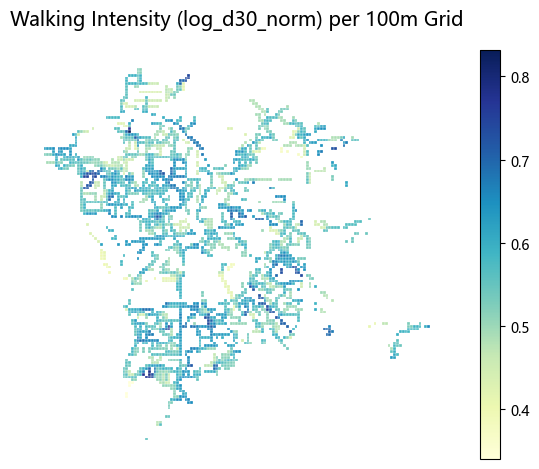

In [293]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
ax = grid_valid.plot(
    column='log_d30_norm',
    cmap='YlGnBu',
    legend=True,
    edgecolor='white',
    linewidth=0.2,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

plt.title("Walking Intensity (log_d30_norm) per 100m Grid", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


In [294]:
# === ÂùêÊ†áÁ≥ªËΩ¨Êç¢Ôºö‰ªé WGS84 ËΩ¨‰∏∫ UTM 50N ===
grid_valid_utm = grid_valid.to_crs(epsg=32650)

# === ‰øùÂ≠ò‰∏∫ GeoJSON Êñá‰ª∂ ===
output_path = "‰øùÂ≠òÁªìÊûúÁî®/grid_guangming_valid.geojson"
grid_valid_utm.to_file(output_path, driver="GeoJSON")

print("‚úÖ Â∑≤ÊàêÂäüËΩ¨Êç¢‰∏∫UTM 50NÂπ∂‰øùÂ≠ò‰∏∫ GeoJSONÔºö", output_path)


‚úÖ Â∑≤ÊàêÂäüËΩ¨Êç¢‰∏∫UTM 50NÂπ∂‰øùÂ≠ò‰∏∫ GeoJSONÔºö ‰øùÂ≠òÁªìÊûúÁî®/grid_guangming_valid.geojson


# intervetion

D:\Anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


‚úÖ Ê®°ÂûãÊÄßËÉΩÔºöR¬≤ = 0.6953, RMSE = 0.0458


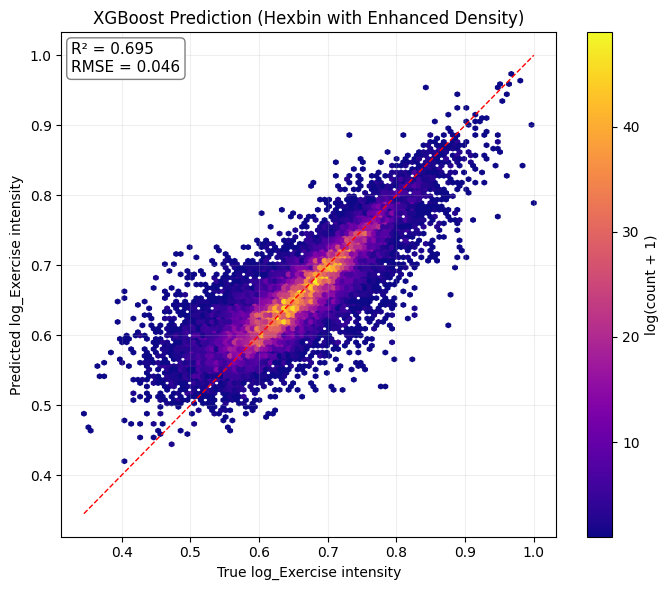

In [2]:
import geopandas as gpd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# === ËØªÂèñÈáçÂëΩÂêçÂêéÁöÑÊï∞ÊçÆ ===
gdf = gpd.read_file("‰øùÂ≠òÁªìÊûúÁî®/SZ_model_input_CPL_renamed.geojson")

# === Á≠õÈÄâÈùûÈõ∂ÁõÆÊ†áÂÄº & ÂêàÊ≥ïÂá∫Ë°åÊñπÂºèÔºàÈùû auto-onlyÔºâ
gdf_filtered = gdf[(gdf['log_d30_norm'] != 0) & (gdf['allow_uses_label'] != 0)]
# gdf_filtered = gdf['allow_uses_label'] != 0
# ÂéªÈô§ÁõÆÊ†áÂíåÈùûÁâπÂæÅÂ≠óÊÆµ
exclude_cols = [
    'log_d10_norm', 'log_d20_norm', 'log_d30_norm',  'poi_entropy100', 'poi_entropy200', 
    'geometry', 'new_id','clo','deg_C','betw1000K','allow_uses_label','L_filtered_weibo_count','C_length','L_poi_entropy200','L_poi_entropy100'
]
feature_cols = [col for col in gdf_filtered.columns if col not in exclude_cols]

# ËÆæÁΩÆ X Âíå y
X = gdf_filtered[feature_cols]
y = gdf_filtered['log_d30_norm']
# ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ËÆ≠ÁªÉÊ®°Âûã
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=8, random_state=42)
model.fit(X_train, y_train)

# È¢ÑÊµã‰∏éËØÑ‰º∞
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"‚úÖ Ê®°ÂûãÊÄßËÉΩÔºöR¬≤ = {r2:.4f}, RMSE = {rmse:.4f}")
plt.figure(figsize=(7, 6))

# Hexbin ÂõæÔºàÂ¢ûÂº∫ÂØÜÂ∫¶Ôºâ
hb = plt.hexbin(
    y_test, y_pred,
    gridsize=100,
    cmap='plasma',
    reduce_C_function=np.log1p,
    mincnt=1
)

# ÂèÇËÄÉÁ∫ø
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1)

# Â∑¶‰∏äËßíÊ†áÊ≥® R¬≤ Âíå RMSE
plt.text(
    0.02, 0.98,
    f"R¬≤ = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    horizontalalignment='left',
    fontsize=11,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# Ê†áÊ≥®
plt.xlabel("True log_Exercise intensity")
plt.ylabel("Predicted log_Exercise intensity")
plt.title("XGBoost Prediction (Hexbin with Enhanced Density)")

# Ëâ≤Êù°ÂíåÈÄèÊòéÁΩëÊ†º
plt.colorbar(hb, label='log(count + 1)')
plt.grid(alpha=0.2)  # Êõ¥Ê∑°ÁöÑÁΩëÊ†ºÁ∫ø
plt.tight_layout()
plt.show()


Á¶èÁî∞Âå∫Ê®°ÂûãÔºöR¬≤ = 0.5907, RMSE = 0.0474


D:\Anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


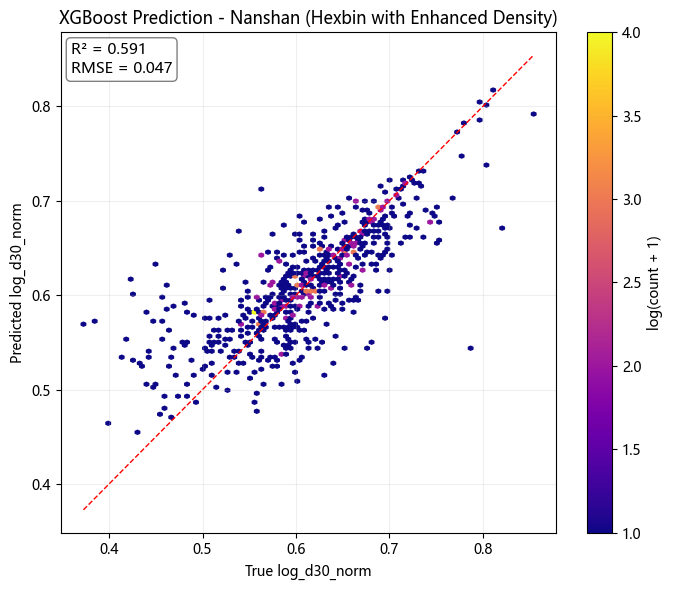

In [7]:
plt.rcParams['font.family'] = 'Microsoft YaHei'   # WindowsÁî®Êà∑ÔºàÊé®ËçêÔºâ

import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# === 1. ËØªÂèñË°åÊîøËæπÁïå ===
# admin_gdf = gpd.read_file("Ë°åÊîøËæπÁïå/Ê∑±Âú≥_ÂéøÁ∫ßÂå∫Âàí.shp")

# === 2. ÊäïÂΩ±ËΩ¨Êç¢ÂåπÈÖç ===
# admin_gdf = admin_gdf.to_crs(gdf_filtered.crs)

# === 3. ÈÄâÂá∫ÁõÆÊ†áË°åÊîøÂå∫ ===
futian_poly = admin_gdf[admin_gdf['ÂéøÁ∫ß'] == 'ÂÖâÊòéÂå∫'].geometry.values[0]

# === 4. Á©∫Èó¥Â≠êÈõÜÔºàÁ¶èÁî∞Âå∫Ôºâ===
gdf_futian = gdf_filtered[gdf_filtered.geometry.within(futian_poly)]

# === 5. ÁâπÂæÅÂáÜÂ§á ===
X_futian = gdf_futian[feature_cols]
y_futian = gdf_futian['log_d30_norm']

X_train, X_test, y_train, y_test = train_test_split(
    X_futian, y_futian, test_size=0.2, random_state=42
)

# === 6. Ê®°ÂûãËÆ≠ÁªÉ‰∏éÈ¢ÑÊµã ===
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=8, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === 7. ÊÄßËÉΩËØÑ‰º∞ ===
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Á¶èÁî∞Âå∫Ê®°ÂûãÔºöR¬≤ = {r2:.4f}, RMSE = {rmse:.4f}")

plt.figure(figsize=(7, 6))

# Hexbin ÂõæÔºàÂ¢ûÂº∫ÂØÜÂ∫¶Ôºâ
hb = plt.hexbin(
    y_test, y_pred,
    gridsize=100,
    cmap='plasma',
    reduce_C_function=np.log1p,
    mincnt=1
)

# ÂèÇËÄÉÁ∫ø
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1)

# Â∑¶‰∏äËßíÊ†áÊ≥® R¬≤ Âíå RMSE
plt.text(
    0.02, 0.98,
    f"R¬≤ = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    horizontalalignment='left',
    fontsize=11,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# Ê†áÊ≥®
plt.xlabel("True log_d30_norm")
plt.ylabel("Predicted log_d30_norm")
plt.title("XGBoost Prediction - Nanshan (Hexbin with Enhanced Density)")

# Ëâ≤Êù°ÂíåÈÄèÊòéÁΩëÊ†º
plt.colorbar(hb, label='log(count + 1)')
plt.grid(alpha=0.2)  # Êõ¥Ê∑°ÁöÑÁΩëÊ†ºÁ∫ø
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_27204\832521923.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


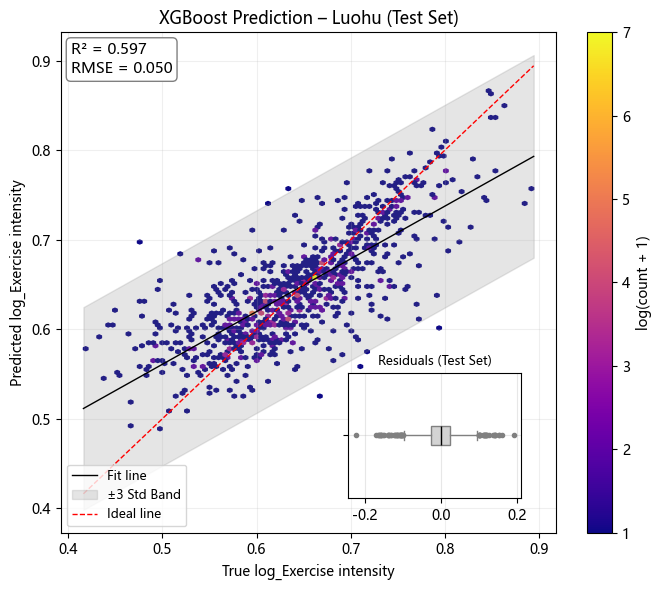

In [158]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# === ‰∏ªÂõæÔºöÊµãËØïÈõÜÈ¢ÑÊµã Hexbin ===
fig, ax = plt.subplots(figsize=(7, 6))

hb = ax.hexbin(
    y_test, y_pred,
    gridsize=100,
    cmap='plasma',
    reduce_C_function=np.log1p,
    mincnt=1
)

# === ÊãüÂêàÁ∫ø + ÁΩÆ‰ø°Âå∫Èó¥ ===
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
x_line = np.linspace(y_test.min(), y_test.max(), 200)
y_fit = p(x_line)
fit_residuals = y_pred - p(y_test)
std = np.std(fit_residuals)
y_upper = y_fit + 3 * std
y_lower = y_fit - 3 * std

ax.plot(x_line, y_fit, "k-", lw=1, label="Fit line")
ax.fill_between(x_line, y_lower, y_upper, color='gray', alpha=0.2, label="¬±3 Std Band")
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1, label="Ideal line")

# === R¬≤ Âíå RMSE Ê†áÊ≥® ===
ax.text(
    0.02, 0.98,
    f"R¬≤ = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=ax.transAxes,
    verticalalignment='top',
    horizontalalignment='left',
    fontsize=11,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# === ‰∏ªÂõæËÆæÁΩÆ ===
ax.set_xlabel("True log_Exercise intensity")
ax.set_ylabel("Predicted log_Exercise intensity")
ax.set_title("XGBoost Prediction ‚Äì Luohu (Test Set)")
ax.grid(alpha=0.2)
plt.colorbar(hb, ax=ax, label='log(count + 1)')

# === Â≠êÂõæÔºöÊÆãÂ∑ÆÁÆ±ÂûãÂõæÔºå‰ΩçÁΩÆ‰∏äÁßª ===
residuals = y_test - y_pred
inset_ax = inset_axes(ax, width="35%", height="25%", loc='lower right', borderpad=2.5)

inset_ax.boxplot(residuals, vert=False, patch_artist=True,
                 boxprops=dict(facecolor='lightgray', color='gray'),
                 medianprops=dict(color='black'),
                 whiskerprops=dict(color='gray'),
                 capprops=dict(color='gray'),
                 flierprops=dict(marker='o', markersize=3, markerfacecolor='gray', markeredgecolor='gray'))

inset_ax.set_title("Residuals (Test Set)", fontsize=9)
inset_ax.tick_params(axis='y', labelleft=False)
inset_ax.grid(alpha=0.3)

# === Âõæ‰æãÁßªÂä®Âà∞Â∑¶‰∏ãËßíÔºåÈÅøÂÖçÈÅÆÊå°ÊñáÂ≠ó ===
ax.legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.savefig("‰øùÂ≠òÁªìÊûúÁî®/Âà∂Âõæ/ÁΩóÊπñÊï£ÁÇπ.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()


In [8]:
import shap
import pandas as pd

# ÊûÑÂª∫ explainer
explainer = shap.Explainer(model)

# ËÆ°ÁÆó SHAP
print("üìä Ê≠£Âú®ËÆ°ÁÆóÂÖâÊòéÂå∫ SHAP ÂÄº...")
shap_values = explainer(X_futian)

# ‰øùÂ≠ò SHAP
shap_df_futian = pd.DataFrame(shap_values.values, columns=X_futian.columns)
shap_df_futian['new_id'] = gdf_futian['new_id'].values
# shap_df_futian.to_csv("‰øùÂ≠òÁªìÊûúÁî®/Yantian_shap_all.csv", index=False)

üìä Ê≠£Âú®ËÆ°ÁÆóÂÖâÊòéÂå∫ SHAP ÂÄº...


In [ ]:
# === SHAP DataFrame ===
shap_df = pd.DataFrame(shap_values.values, columns=X_futian.columns)

# === Step 1: ÈÄâÂá∫ L_ ÁªÑÂèòÈáè ===
L_cols = [col for col in X_futian.columns if col.startswith("P_")]

# === Step 2: Ëé∑ÂèñÂπ≥ÂùáÁªùÂØπ SHAP ÂÄºÊúÄÂ§ßÁöÑÂâç5‰∏™ L ÂèòÈáè ===
L_abs_mean = shap_df[L_cols].abs().mean()
top5_L = L_abs_mean.sort_values(ascending=False).head(5).index.tolist()
print("‚úÖ Top 5 LÁªÑÂèòÈáèÔºàÊåâÁªùÂØπSHAPÂÄºÔºâ:", top5_L)

# === Step 3: Âà§Êñ≠ SHAP Ê≠£Ë¥üÔºåÊâßË°åÂÆöÂêëÂπ≤È¢Ñ ===
X_intervened = X_futian.copy()

for var in top5_L:
    direction = shap_df[var].mean()
    if direction > 0:
        X_intervened[var] = np.minimum(X_futian[var] * 1.2, 1.0)  # Ê≠£Âêë‰∏äË∞É
        print(f"üîº {var} ‰∏∫Ê≠£ÂêëÂèòÈáèÔºåÊâßË°å +20%")
    elif direction < 0:
        X_intervened[var] = X_futian[var] * 0.8  # Ë¥üÂêë‰∏ãË∞É
        print(f"üîΩ {var} ‰∏∫Ë¥üÂêëÂèòÈáèÔºåÊâßË°å -20%")
    else:
        print(f"‚ö†Ô∏è {var} SHAP ÂùáÂÄº‰∏∫0ÔºåË∑≥ËøáÂπ≤È¢Ñ")
y_pred_before = model.predict(X_futian)
y_pred_after = model.predict(X_intervened)
improve_ratio = (y_pred_after.mean() - y_pred_before.mean()) / y_pred_before.mean() * 100
print(f"\nüìà Âπ≤È¢ÑÂêéÂπ≥ÂùáÈ¢ÑÊµãÊèêÂçáÔºö{improve_ratio:.2f}%")


In [297]:
import pandas as pd
import numpy as np

# === Step 1: ÁîüÊàê SHAP DataFrameÔºàÂ¶ÇÊûúÊú™ÁîüÊàêÔºâ===
shap_df = pd.DataFrame(shap_values.values, columns=X_futian.columns)

# === Step 2: Ëé∑Âèñ L_ Âíå P_ ÁöÑ SHAP ÂÄºÂàó ===
L_cols = [col for col in X_futian.columns if col.startswith("L_")]
P_cols = [col for col in X_futian.columns if col.startswith("P_")]
C_cols = [col for col in X_futian.columns if col.startswith("C_")]

# === Step 3: ÈÄâÂá∫ÊØèÁªÑ SHAP ÁªùÂØπÂÄº Top5 ÂèòÈáè ===
top5_L = shap_df[L_cols].abs().mean().sort_values(ascending=False).head(5).index.tolist()
top5_P = shap_df[P_cols].abs().mean().sort_values(ascending=False).head(5).index.tolist()
top5_C = shap_df[C_cols].abs().mean().sort_values(ascending=False).head(5).index.tolist()

# === Step 4: Âπ≤È¢ÑÈÄªËæë ===
X_intervened = X_futian.copy()

def apply_directional_change(df, var_list, label=""):
    for var in var_list:
        shap_mean = shap_df[var].mean()
        if shap_mean > 0:
            df[var] = np.minimum(df[var] * 0.8, 1.0)
            print(f"üîº {label}{var} ‚Üë (SHAPÊ≠£ÂùáÂÄº ‚Üí ‰∏äË∞É 20%)")
        elif shap_mean < 0:
            df[var] = df[var] * 1.2
            print(f"üîΩ {label}{var} ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)")
        else:
            print(f"‚ö†Ô∏è {label}{var} SHAP ÂùáÂÄº‚âà0ÔºåË∑≥Ëøá")
    return df

X_intervened = apply_directional_change(X_intervened, top5_L, "L:")
X_intervened = apply_directional_change(X_intervened, top5_P, "P:")
X_intervened = apply_directional_change(X_intervened, top5_C, "C:")

# === Step 5: Ê®°ÂûãÈ¢ÑÊµãÂπ≤È¢ÑÂâçÂêé ===
y_pred_before = model.predict(X_futian)
y_pred_after = model.predict(X_intervened)

# === Step 6: ËæìÂá∫ÊèêÂçáÁôæÂàÜÊØî ===
improve_ratio = (y_pred_after.mean() - y_pred_before.mean()) / y_pred_before.mean() * 100
print(f"\nüìà L+P+C Âπ≤È¢ÑÂêéÂπ≥ÂùáËøêÂä®È¢ÑÊµãÊèêÂçáÔºö{improve_ratio:.2f}%")

# === Step 7: ‰øùÂ≠òÂà∞ gdf_futian ÂèØËßÜÂåñÊèêÂçá ===
gdf_futian = gdf_futian.copy()
gdf_futian['gain_LP'] = y_pred_after - y_pred_before


üîº L:L_poi_entropy300 ‚Üë (SHAPÊ≠£ÂùáÂÄº ‚Üí ‰∏äË∞É 20%)
üîΩ L:L_positive_mean ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)
üîº L:L_context_mean ‚Üë (SHAPÊ≠£ÂùáÂÄº ‚Üí ‰∏äË∞É 20%)
üîº L:L_sport_mean ‚Üë (SHAPÊ≠£ÂùáÂÄº ‚Üí ‰∏äË∞É 20%)
üîΩ L:L_total_weibo_count ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)
üîΩ P:P_car ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)
üîΩ P:P_building ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)
üîº P:P_traffic si ‚Üë (SHAPÊ≠£ÂùáÂÄº ‚Üí ‰∏äË∞É 20%)
üîº P:P_terrain ‚Üë (SHAPÊ≠£ÂùáÂÄº ‚Üí ‰∏äË∞É 20%)
üîΩ P:P_sky ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)
üîΩ C:C_D_transport ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)
üîº C:C_D_building ‚Üë (SHAPÊ≠£ÂùáÂÄº ‚Üí ‰∏äË∞É 20%)
üîº C:C_D_sparseveg ‚Üë (SHAPÊ≠£ÂùáÂÄº ‚Üí ‰∏äË∞É 20%)
üîΩ C:C_D_farmland ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)
üîΩ C:C_D_tree ‚Üì (SHAPË¥üÂùáÂÄº ‚Üí ‰∏ãË∞É 20%)

üìà L+P+C Âπ≤È¢ÑÂêéÂπ≥ÂùáËøêÂä®È¢ÑÊµãÊèêÂçáÔºö-1.91%


In [14]:
def simulate_single_variable_impact(X_base, model, group_prefix="P_", step=0.1, cap=1.0):
    candidate_vars = [col for col in X_base.columns if col.startswith(group_prefix)]
    y_base = model.predict(X_base)
    base_mean = y_base.mean()

    improvement_dict = {}

    for var in candidate_vars:
        X_temp = X_base.copy()
        X_temp[var] = np.minimum(X_temp[var] * (1 + step), cap)  # ‰∏äË∞ÉÂèòÈáè
        y_new = model.predict(X_temp)
        mean_new = y_new.mean()
        gain = (mean_new - base_mean) / base_mean * 100
        improvement_dict[var] = gain
        print(f"üîç {var}: +{int(step*100)}% ‚Üí È¢ÑÊµã‰∏äÂçá {gain:.2f}%")

    # ËøîÂõûÊåâÊèêÂçáÊïàÊûúÊéíÂ∫èÁöÑÁªìÊûú
    return pd.Series(improvement_dict).sort_values(ascending=False)
top_c_candidates = simulate_single_variable_impact(X_futian, model, group_prefix="L_", step=0.3)
print("\nüìà Top 5 CÁªÑ‰∏≠ÊúÄÂÖ∑ÊèêÂçáÊΩúÂäõÂèòÈáèÔºö")
print(top_c_candidates.head(5))


üîç L_poi_entropy300: +30% ‚Üí È¢ÑÊµã‰∏äÂçá -1.27%
üîç L_urban_mean: +30% ‚Üí È¢ÑÊµã‰∏äÂçá 0.22%
üîç L_positive_mean: +30% ‚Üí È¢ÑÊµã‰∏äÂçá 1.07%
üîç L_sport_mean: +30% ‚Üí È¢ÑÊµã‰∏äÂçá 0.20%
üîç L_context_mean: +30% ‚Üí È¢ÑÊµã‰∏äÂçá -0.81%
üîç L_total_weibo_count: +30% ‚Üí È¢ÑÊµã‰∏äÂçá 1.40%

üìà Top 5 CÁªÑ‰∏≠ÊúÄÂÖ∑ÊèêÂçáÊΩúÂäõÂèòÈáèÔºö
L_total_weibo_count    1.398758
L_positive_mean        1.067804
L_urban_mean           0.224147
L_sport_mean           0.196662
L_context_mean        -0.813545
dtype: float64


üîç C_Direction: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.00%
üîç C_lanes: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.09%
üîç C_free_speed: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.01%
üîç C_capacity: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.08%
üîç C_link_type: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.00%
üîç L_poi_entropy300: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.21%
üîç L_urban_mean: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.03%
üîç L_positive_mean: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.26%
üîç L_sport_mean: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.02%
üîç L_context_mean: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.03%
üîç C_D_transport: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -7.96%
üîç C_D_tree: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.28%
üîç C_D_grass: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.01%
üîç C_D_farmland: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.60%
üîç C_D_building: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -2.49%
üîç C_D_sparseveg: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -1.24%
üîç C_D_water: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.59%
üîç C_800_deg_C: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.59%
üîç C_betw_800m: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.08%
üîç C_clo_800m: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.14%
üîç C_depth_800m: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.11%
üîç P_road

C:\Users\admin\AppData\Local\Temp\ipykernel_9908\1877892259.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_neg = plt.cm.get_cmap("Greys_r", 128)  # ‰ªéÈªëÂà∞ÁÅ∞
C:\Users\admin\AppData\Local\Temp\ipykernel_9908\1877892259.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_pos = plt.cm.get_cmap("Reds", 128)     # ‰ªéÁÅ∞Âà∞Á∫¢


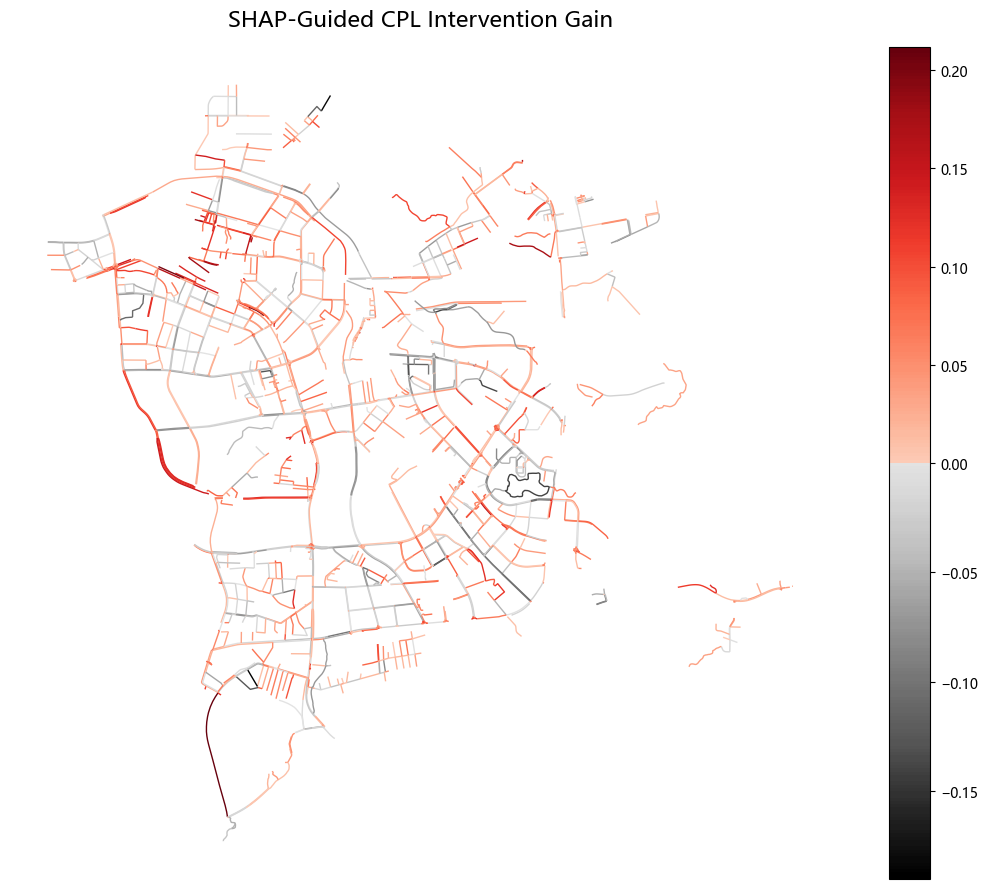

In [9]:
def simulate_joint_variable_with_output(
    X_base, model, gdf_base, group_prefixes=["P_"], step=0.2, cap=1.0, top_k=8, label="gain_P"
):
    # === Step 1: Ëé∑ÂèñÂèòÈáè ===
    candidate_vars = [
        col for col in X_base.columns if any(col.startswith(p) for p in group_prefixes)
    ]
    y_base = model.predict(X_base)
    base_mean = y_base.mean()

    # === Step 2: ÂçïÂèòÈáèÂπ≤È¢ÑÊ®°Êãü ===
    improvement_dict = {}
    for var in candidate_vars:
        X_temp = X_base.copy()
        X_temp[var] = np.minimum(X_temp[var] * (1 + step), cap)
        y_new = model.predict(X_temp)
        gain = (y_new.mean() - base_mean) / base_mean * 100
        improvement_dict[var] = gain
        print(f"üîç {var}: +{int(step*100)}% ‚Üí Âπ≥ÂùáÊèêÂçá {gain:.2f}%")

    # === Step 3: ËÅîÂêàÂπ≤È¢Ñ top-K ÂèòÈáè ===
    top_k_vars = sorted(improvement_dict, key=improvement_dict.get, reverse=True)[:top_k]
    print(f"\n‚úÖ Top-{top_k} ËÅîÂêàÂπ≤È¢ÑÂèòÈáè (Êù•Ëá™ {'/'.join(group_prefixes)}): {top_k_vars}")

    X_joint = X_base.copy()
    for var in top_k_vars:
        X_joint[var] = np.minimum(X_joint[var] * (1 + step), cap)

    y_joint = model.predict(X_joint)
    residual = y_joint - y_base
    gain_pct = (y_joint.mean() - y_base.mean()) / y_base.mean() * 100

    print(f"üìà Âπ≤È¢ÑÂêéÈ¢ÑÊµãÂùáÂÄºÊèêÂçáÔºö{gain_pct:.2f}%")

    # === Step 4: ‰øùÂ≠òÁªìÊûúÂà∞ gdf
    gdf_result = gdf_base.copy()
    gdf_result[label] = residual

    import matplotlib.pyplot as plt
    
    # fig, ax = plt.subplots(figsize=(12, 9))
    
    # # Ê≠£Á°Æ‰ΩøÁî® gdf_result ËÄå‰∏çÊòØ gdf_futian
    # gdf_result.plot(
    #     column=label,               # Ëá™Âä®‰ΩøÁî® gain_P
    #     cmap='coolwarm',
    #     legend=True,
    #     linewidth=1.2,
    #     ax=ax,
    #     missing_kwds={"color": "lightgrey", "label": "No Data"}
    # )
    
    # ax.set_title("SHAP-Guided PÁ©∫Èó¥Âπ≤È¢ÑÂêéÈÅìË∑ØËøêÂä®ÊèêÂçá", fontsize=16, pad=15)
    # ax.set_axis_off()
    # plt.tight_layout()
    # plt.show()
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from matplotlib.colors import TwoSlopeNorm
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # ËÆæÁΩÆÊúÄÂ§ßÊúÄÂ∞èÂÄºÔºåÁî®‰∫éÊ∏êÂèòËâ≤Ê†áÂáÜÂåñ
    vmin = gdf_result[label].min()
    vmax = gdf_result[label].max()
    
    # ÊûÑÂª∫Ê∏êÂèòËâ≤Â∏¶Ôºö
    # ÂâçÂçäÔºöÈªëËâ≤ ‚Üí ÁÅ∞Ëâ≤ÔºàË¥üÂÄºÔºâ
    # ÂêéÂçäÔºöÁÅ∞Ëâ≤ ‚Üí Á∫¢Ëâ≤ÔºàÊ≠£ÂÄºÔºâ
    cmap_neg = plt.cm.get_cmap("Greys_r", 128)  # ‰ªéÈªëÂà∞ÁÅ∞
    cmap_pos = plt.cm.get_cmap("Reds", 128)     # ‰ªéÁÅ∞Âà∞Á∫¢
    
    # ÊãºÊé•‰∏∫‰∏ÄÊù°ËøûÁª≠ colormap
    new_colors = np.vstack((
        cmap_neg(np.linspace(0.0, 0.8, 128)),   # ÊéßÂà∂ÁÅ∞Ëâ≤Á®ãÂ∫¶
        cmap_pos(np.linspace(0.2, 1.0, 128))
    ))
    custom_cmap = mcolors.ListedColormap(new_colors, name='black_grey_red')
    
    # ËÆæÁΩÆÂèåËæπÊ†áÂáÜÂåñÔºö‰ª•0‰∏∫‰∏≠ÁÇπ
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    # ÁªòÂõæ
    gdf_result.plot(
        column=label,
        cmap=custom_cmap,
        norm=norm,
        legend=True,
        linewidth=1.0,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No Data"}
    )
    
    ax.set_title("SHAP-Guided CPL Intervention Gain", fontsize=16, pad=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()




    return gdf_result, top_k_vars, gain_pct
gdf_futian, top_vars_P, avg_gain = simulate_joint_variable_with_output(
    X_base=X_futian,
    model=model,
    gdf_base=gdf_futian,
    group_prefixes=["P_","C_","L_"],
    step=0.2,
    cap=1.0,
    top_k=20,
    label="gain_P"
)


In [10]:
gdf_futian["y_base"] = model.predict(X_futian)
gdf_futian

C_Direction   C_length  C_lanes  C_free_speed  C_capacity  \
15969           1.0  331.83206      2.0          60.0      1600.0   
15970           1.0  816.64355      3.0          80.0      1800.0   
15973           1.0   23.39010      3.0          80.0      1800.0   
15975           1.0   19.70045      3.0          80.0      1800.0   
15977           1.0  338.06200      3.0          80.0      1800.0   
...             ...        ...      ...           ...         ...   
111746          1.0  252.23200      1.0           5.0       800.0   
111748          1.0  198.94174      1.0           5.0       800.0   
111788          0.0  260.08991      1.0          30.0      1000.0   
111789          0.0  165.61643      1.0          30.0      1000.0   
111791          0.0  284.59176      1.0          30.0      1000.0   

        C_link_type  L_poi_entropy300  L_poi_entropy200  L_poi_entropy100  \
15969           4.0          1.231974          0.325083         -0.000000   
15970           3.0          1.634155          1.429310          0.486913   
15973           3.0         -0.000000          0.000000          0.000000   
15975           3.0         -0.000000          0.000000          0.000000   
15977           3.0         -0.000000         -0.000000          0.000000   
...             ...               ...               ...               ...   
111746          9.0          0.562335          0.000000          0.000000   
111748          9.0          0.000000          0.000000          0.000000   
111788          6.0          1.329279          0.882609          0.223718   
111789          6.0          1.335372          0.845505         -0.000000   
111791          6.0          1.089615          1.188183          1.549826   

        L_urban_mean  ...  P_bicycle  L_total_weibo_count  \
15969       0.000000  ...   0.117783             0.000000   
15970       0.391481  ...   0.060625             6.293419   
15973       0.000000  ...   3.996949             0.000000   
15975       0.000000  ...   3.996949             0.000000   
15977       0.000000  ...   3.851918             0.000000   
...              ...  ...        ...                  ...   
111746      0.000000  ...   0.000000             0.000000   
111748      0.000000  ...   0.000000             0.000000   
111788      0.000000  ...   3.584291             0.000000   
111789      0.000000  ...   4.209160             0.000000   
111791      0.391481  ...   5.860802             6.293419   

        L_filtered_weibo_count  log_d10_norm  log_d20_norm  log_d30_norm  \
15969                 0.000000      0.000000      0.000000      0.433722   
15970                 4.912655      0.461902      0.507791      0.606472   
15973                 0.000000      0.000000      0.000000      0.617321   
15975                 0.000000      0.000000      0.578348      0.667177   
15977                 0.000000      0.000000      0.387357      0.588561   
...                        ...           ...           ...           ...   
111746                0.000000      0.506490      0.521965      0.526477   
111748                0.000000      0.607059      0.589330      0.582578   
111788                0.000000      0.619834      0.603097      0.596627   
111789                0.000000      0.000000      0.000000      0.630302   
111791                4.912655      0.000000      0.000000      0.441033   

        new_id                                           geometry    gain_P  \
15969    18954  LINESTRING (179681.275 2518091.84, 179698.182 ...  0.076229   
15970    18955  LINESTRING (179681.275 2518091.84, 179703.214 ...  0.008608   
15973    18964  LINESTRING (178014.65 2524084.334, 178025.154 ...  0.005580   
15975    18966  LINESTRING (178032.526 2524092.613, 178014.65 ... -0.019964   
15977    18968  LINESTRING (178025.154 2524063.435, 178058.413... -0.000723   
...        ...                                                ...       ...   
111746  141770  LINESTRING (187889.278 2524103.251, 187

In [12]:
import geopandas as gpd

# ËØªÂèñÈîôÈÖçÂå∫ÂüüÔºàgrid LISA ÁªìÊûú‰∏≠Á≠õÈÄâÂêéÁöÑÈÉ®ÂàÜÔºâ
grid_mismatch = gpd.read_file("‰øùÂ≠òÁªìÊûúÁî®/grid_guangming_valid_mismatch.geojson")

# ‰∏é gdf_result ‰øùÊåÅ‰∏ÄËá¥ÁöÑ CRS
grid_mismatch = grid_mismatch.to_crs(gdf_futian.crs)

# ‰ªÖ‰øùÁïô‰∏éÈîôÈÖçÂå∫ÂüüÁõ∏‰∫§ÁöÑÈÅìË∑ØÔºàÊ≥®ÊÑè‰ΩøÁî® geometry ËÄåÈùû centroidÔºâ
gdf_futian_mismatch = gdf_futian[gdf_futian.geometry.intersects(grid_mismatch.unary_union)].copy()

print(f"‚úÖ ÈÄâÂá∫ {len(gdf_futian_mismatch)} Êù°‰∏éÈîôÈÖçÂå∫ÂüüÁõ∏‰∫§ÁöÑÈÅìË∑Ø")


C:\Users\admin\AppData\Local\Temp\ipykernel_9908\827771984.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_futian_mismatch = gdf_futian[gdf_futian.geometry.intersects(grid_mismatch.unary_union)].copy()


‚úÖ ÈÄâÂá∫ 963 Êù°‰∏éÈîôÈÖçÂå∫ÂüüÁõ∏‰∫§ÁöÑÈÅìË∑Ø


In [13]:
# Ëé∑ÂèñÂπ≤È¢ÑÂèòÈáè residualÔºàÊèêÂçáÂÄºÔºâ‰∏é y_baseÔºàÂéüÂßãÈ¢ÑÊµãÔºâ
gdf_futian_mismatch["y_after"] = gdf_futian_mismatch["y_base"] + gdf_futian_mismatch["gain_P"]
gdf_futian_mismatch["gain_pct"] = (gdf_futian_mismatch["y_after"] - gdf_futian_mismatch["y_base"]) / gdf_futian_mismatch["y_base"] * 100

print("üìà Âπ≥ÂùáÊèêÂçáÔºö", gdf_futian_mismatch["gain_pct"].mean(), "%")


üìà Âπ≥ÂùáÊèêÂçáÔºö 6.708729 %


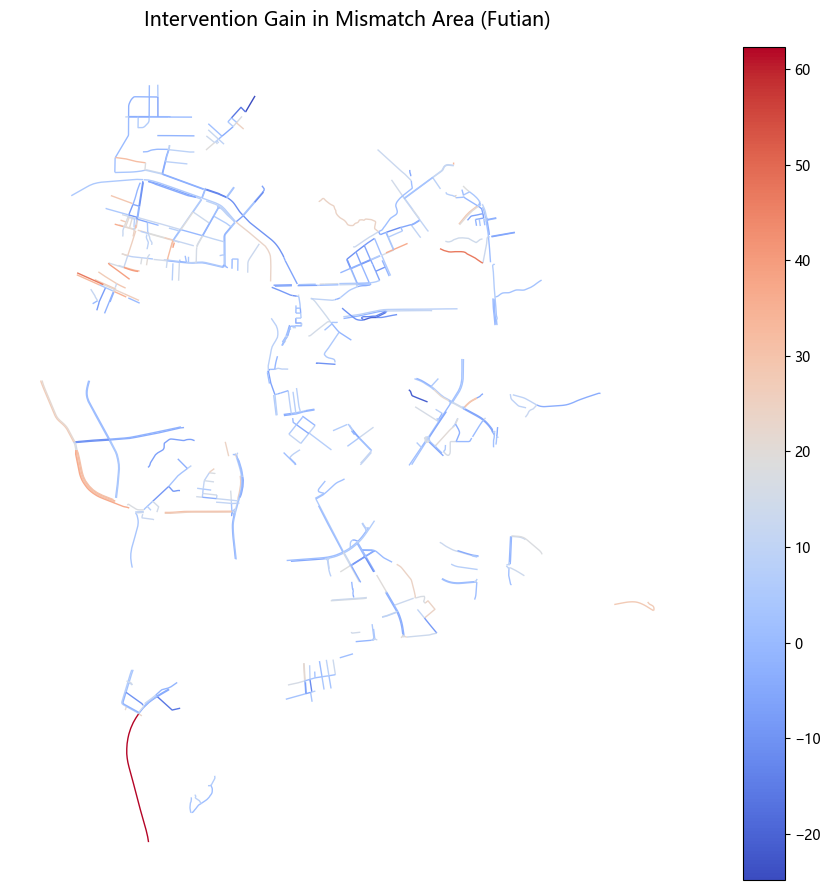

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))
gdf_futian_mismatch.plot(
    column="gain_pct",
    cmap="coolwarm",
    legend=True,
    linewidth=1.0,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)
ax.set_title("Intervention Gain in Mismatch Area (Futian)", fontsize=14, pad=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()


üîç L_poi_entropy300: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.68%
üîç L_urban_mean: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.06%
üîç L_positive_mean: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.05%
üîç L_sport_mean: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.07%
üîç L_context_mean: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.01%
üîç P_road: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 1.01%
üîç P_sidewalk: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.97%
üîç P_building: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.78%
üîç P_wall: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 1.08%
üîç P_fence: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.48%
üîç P_pole: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.33%
üîç P_traffic li: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.02%
üîç P_traffic si: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.58%
üîç P_vegetation: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.06%
üîç P_terrain: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.06%
üîç P_sky: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.58%
üîç P_person: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -1.53%
üîç P_rider: +20% ‚Üí Âπ≥ÂùáÊèêÂçá -0.63%
üîç P_car: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 2.64%
üîç P_truck: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 1.54%
üîç P_bus: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.43%
üîç P_train: +20% ‚Üí Âπ≥ÂùáÊèêÂçá 0.40%
üîç P_motorcycle: 

C:\Users\admin\AppData\Local\Temp\ipykernel_27204\1877892259.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_neg = plt.cm.get_cmap("Greys_r", 128)  # ‰ªéÈªëÂà∞ÁÅ∞
C:\Users\admin\AppData\Local\Temp\ipykernel_27204\1877892259.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_pos = plt.cm.get_cmap("Reds", 128)     # ‰ªéÁÅ∞Âà∞Á∫¢


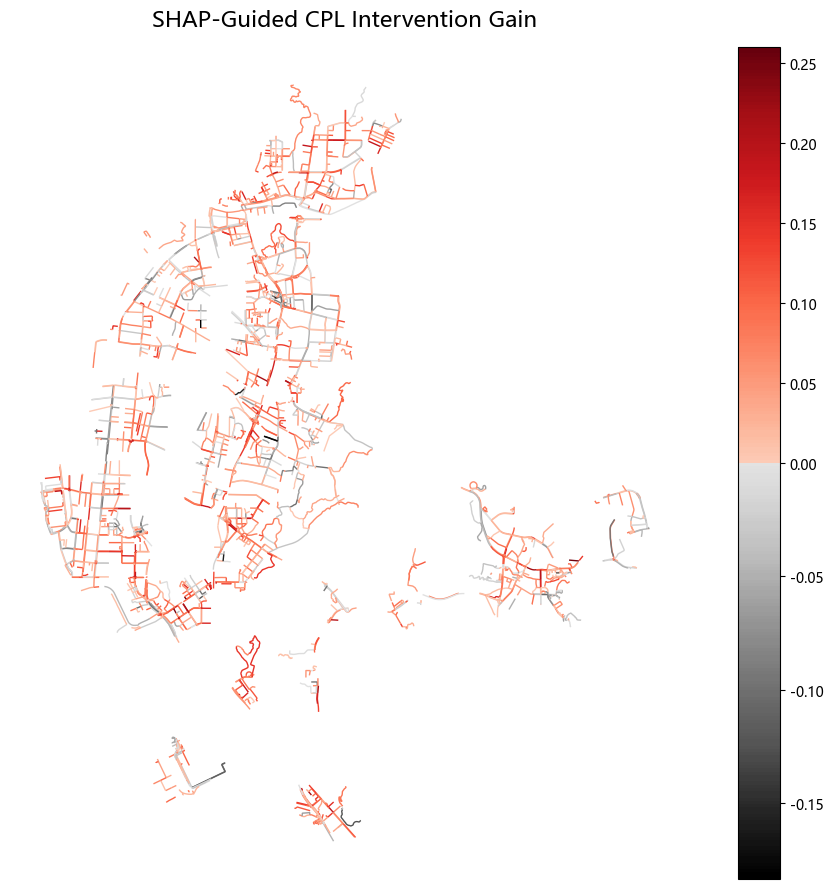

In [227]:

# Á°Æ‰øùÂåπÈÖçÁöÑÁâπÂæÅÂ≠óÊÆµ
X_futian_mismatch = gdf_futian_mismatch[X_futian.columns]
gdf_futian_mismatch_updated, top_vars_selected, avg_gain_pct = simulate_joint_variable_with_output(
    X_base=X_futian_mismatch,
    model=model,
    gdf_base=gdf_futian_mismatch,
    group_prefixes=["P_", "L_"],
    step=0.2,
    cap=1.0,
    top_k=12,
    label="gain_CPL"
)


In [75]:
gdf_futian_mismatch_updated.to_file("‰øùÂ≠òÁªìÊûúÁî®/futian_mismatch_gain.geojson", driver="GeoJSON")

üîç C_Direction: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.00%
üîç C_lanes: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -0.13%
üîç C_free_speed: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.09%
üîç C_capacity: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -0.08%
üîç C_link_type: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.03%
üîç L_poi_entropy300: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.13%
üîç L_urban_mean: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.04%
üîç L_positive_mean: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -0.45%
üîç L_sport_mean: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.02%
üîç L_context_mean: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.05%
üîç C_D_transport: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -6.13%
üîç C_D_tree: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.50%
üîç C_D_grass: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.01%
üîç C_D_farmland: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -0.49%
üîç C_D_building: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -2.65%
üîç C_D_sparseveg: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -0.97%
üîç C_D_water: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -0.45%
üîç C_800_deg_C: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 1.05%
üîç C_betw_800m: +30% ‚Üí Âπ≥ÂùáÊèêÂçá -0.09%
üîç C_clo_800m: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.25%
üîç C_depth_800m: +30% ‚Üí Âπ≥ÂùáÊèêÂçá 0.08%
üîç P_road: +30

C:\Users\admin\AppData\Local\Temp\ipykernel_9908\1877892259.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_neg = plt.cm.get_cmap("Greys_r", 128)  # ‰ªéÈªëÂà∞ÁÅ∞
C:\Users\admin\AppData\Local\Temp\ipykernel_9908\1877892259.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_pos = plt.cm.get_cmap("Reds", 128)     # ‰ªéÁÅ∞Âà∞Á∫¢


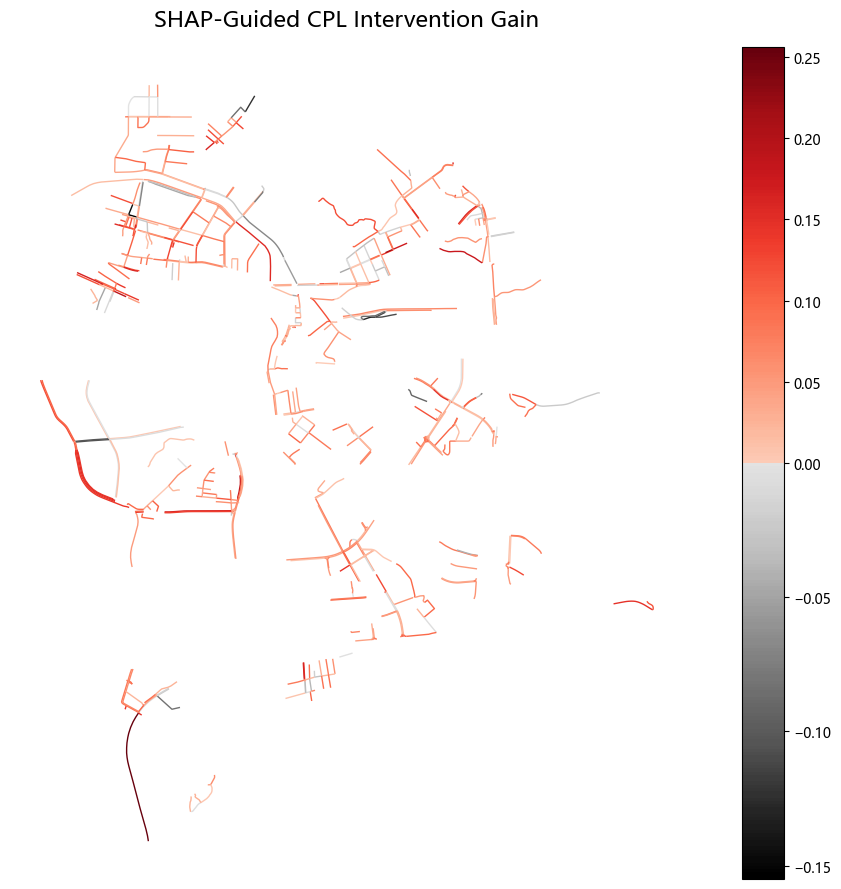

In [15]:

# Á°Æ‰øùÂåπÈÖçÁöÑÁâπÂæÅÂ≠óÊÆµ
X_futian_mismatch = gdf_futian_mismatch[X_futian.columns]
gdf_futian_mismatch_updated, top_vars_selected, avg_gain_pct = simulate_joint_variable_with_output(
    X_base=X_futian_mismatch,
    model=model,
    gdf_base=gdf_futian_mismatch,
    group_prefixes=[ "L_","P_","C_"],
    step=0.3,
    cap=1.0,
    top_k=15,
    label="gain_CPL"
)
